# 1. 개발환경 구성

## 1-1) 라이브러리 가져오기

In [116]:
# os, 환경변수 관련
import os
from dotenv import load_dotenv

#시각화 관련
from matplotlib import rc
from matplotlib import font_manager
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import warnings

# pyspark session 생성
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum, round, mean, lit, concat

# pyspark 학습 준비
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# pyspark 학습
from pyspark.ml.regression import LinearRegression

# pyspark 모델 평가
from pyspark.ml.evaluation import RegressionEvaluator

## 1-2) 환경 설정

### 1-2-1) MySQL 연결

In [123]:
load_dotenv()

host_ip = os.getenv('host_ip')
DATABASE = os.getenv('DATABASE')
user_id = os.getenv('user_id')
user_password = os.getenv('user_password')

# 환경변수 설정
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/mysql-connector-java-5.1.49-bin.jar pyspark-shell'

### 1-2-2) 시각화 관련

In [186]:
font_path = "/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf"

# 폰트 설정
font_prop = font_manager.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

# 경고 무시
warnings.filterwarnings('ignore')

# 음수 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 1-3) spark session 생성

In [3]:
ss = SparkSession\
            .builder\
            .appName('MySQL')\
            .config('spark.executor.memory', '6g')\
            .config('spark.driver.memory', '6g')\
            .getOrCreate()
ss

24/12/19 17:20:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## 1-4) MySQL 연결 및 데이터 가져오기

In [4]:
mysql_url = f'jdbc:mysql://{host_ip}:3306/{DATABASE}?useSSL=false'

In [5]:
df_tbAPTPrice = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbAPTPrice'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbAPTPrice.show(10)

+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|접수연도|자치구코드|자치구명|법정동코드|법정동명|지번구분|지번구분명|본번|부번|             건물명|물건금액_만원|건물면적_m2|토지면적_m2| 층|권리구분|취소일|건축년도|  건물용도|신고구분|신고_공인중개사_지역|계약일_DATE|idx|
+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|    2017|     11710|  송파구|     10500|  석촌동|       1|      대지|0282|0000|           은하빌라|        42000|      73.12|         36|  3|        |      |    2004|연립다세대|        |                    | 2017-08-08|  1|
|    2017|     11560|영등포구|     13200|  신길동|        |          |    |    |                   |        60000|     127.44|         86|   |        |      |    1992|단독다가구|        |                    | 2017

In [6]:
df_tbBaseInterestRate = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbBaseInterestRate'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbBaseInterestRate.show(10)

+----------+----------------+
|      date|BaseInterestRate|
+----------+----------------+
|2024-11-28|               3|
|2024-10-11|            3.25|
|2023-01-13|             3.5|
|2022-11-24|            3.25|
|2022-10-12|               3|
|2022-08-25|             2.5|
|2022-07-13|            2.25|
|2022-05-26|            1.75|
|2022-04-14|             1.5|
|2022-01-14|            1.25|
+----------+----------------+
only showing top 10 rows



## 1-5. 데이터 확인

In [7]:
df_tbAPTPrice.printSchema(), df_tbBaseInterestRate.printSchema()

root
 |-- 접수연도: string (nullable = true)
 |-- 자치구코드: string (nullable = true)
 |-- 자치구명: string (nullable = true)
 |-- 법정동코드: string (nullable = true)
 |-- 법정동명: string (nullable = true)
 |-- 지번구분: string (nullable = true)
 |-- 지번구분명: string (nullable = true)
 |-- 본번: string (nullable = true)
 |-- 부번: string (nullable = true)
 |-- 건물명: string (nullable = true)
 |-- 물건금액_만원: string (nullable = true)
 |-- 건물면적_m2: string (nullable = true)
 |-- 토지면적_m2: string (nullable = true)
 |-- 층: string (nullable = true)
 |-- 권리구분: string (nullable = true)
 |-- 취소일: string (nullable = true)
 |-- 건축년도: string (nullable = true)
 |-- 건물용도: string (nullable = true)
 |-- 신고구분: string (nullable = true)
 |-- 신고_공인중개사_지역: string (nullable = true)
 |-- 계약일_DATE: string (nullable = true)
 |-- idx: integer (nullable = true)

root
 |-- date: date (nullable = true)
 |-- BaseInterestRate: string (nullable = true)



(None, None)

In [8]:
df_tbAPTPrice.persist()
df_tbBaseInterestRate.persist()
df_tbAPTPrice.count()

856311

# 2. 전처리

## 2-1) 컬럼 이름 영문화

In [9]:
renamed_columns = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area',  'contract_date', 'idx']

if len(df_tbAPTPrice.columns) == len(renamed_columns):
    renamed_columns_dict = {i : j for i,j in zip(df_tbAPTPrice.columns, renamed_columns)}

for num, i in enumerate(df_tbAPTPrice.columns):
    if i == list(renamed_columns_dict.keys())[num]:
        df_tbAPTPrice = df_tbAPTPrice.withColumnRenamed(i, list(renamed_columns_dict.values())[num])

df_tbAPTPrice.columns

['sumbit_year',
 'jachigu_code',
 'jachigu_name',
 'law_code',
 'law_name',
 'jibun_gubun',
 'jibun_name',
 'real_num',
 'extra_num',
 'building_name',
 'building_price',
 'building_size',
 'land_size',
 'floor',
 'right_gubun',
 'cancel_date',
 'building_year',
 'building_usage',
 'singo_gubun',
 'agent_area',
 'contract_date',
 'idx']

## 2-2) 불필요한 컬럼 삭제

In [10]:
df_tbAPTPrice = \
df_tbAPTPrice.drop('real_num'
                   , 'extra_num'
                   , 'land_size'
                   , 'right_gubun'
                   , 'cancel_date'
                   , 'singo_gubun'
                   , 'agent_area'
                   , 'contract_date')

df_tbAPTPrice.printSchema()

root
 |-- sumbit_year: string (nullable = true)
 |-- jachigu_code: string (nullable = true)
 |-- jachigu_name: string (nullable = true)
 |-- law_code: string (nullable = true)
 |-- law_name: string (nullable = true)
 |-- jibun_gubun: string (nullable = true)
 |-- jibun_name: string (nullable = true)
 |-- building_name: string (nullable = true)
 |-- building_price: string (nullable = true)
 |-- building_size: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- building_year: string (nullable = true)
 |-- building_usage: string (nullable = true)
 |-- idx: integer (nullable = true)



## 2-3) 결측치, 이상치 확인

### 2-3-1) 결측치(NULL) 확인

In [11]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i).isNull() | isnan(i),1)\
            .otherwise(0)
            )\
            .alias(i + '_nulls') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'sumbit_year_nulls': 0,
 'jachigu_code_nulls': 0,
 'jachigu_name_nulls': 0,
 'law_code_nulls': 0,
 'law_name_nulls': 0,
 'jibun_gubun_nulls': 0,
 'jibun_name_nulls': 0,
 'building_name_nulls': 0,
 'building_price_nulls': 0,
 'building_size_nulls': 0,
 'floor_nulls': 0,
 'building_year_nulls': 3711,
 'building_usage_nulls': 0,
 'idx_nulls': 0}

In [12]:
df_tbAPTPrice.selectExpr('*')\
                .where('building_year is NULL')\
                .show(10)

+-----------+------------+------------+--------+---------+-----------+----------+-------------------+--------------+-------------+-----+-------------+--------------+----+
|sumbit_year|jachigu_code|jachigu_name|law_code| law_name|jibun_gubun|jibun_name|      building_name|building_price|building_size|floor|building_year|building_usage| idx|
+-----------+------------+------------+--------+---------+-----------+----------+-------------------+--------------+-------------+-----+-------------+--------------+----+
|       2017|       11500|      강서구|   10300|   화곡동|          1|      대지|         남광아파트|         18000|        51.89|   14|         null|      오피스텔| 142|
|       2017|       11500|      강서구|   10300|   화곡동|          1|      대지|         남광아파트|         18000|        51.89|   10|         null|      오피스텔|1233|
|       2017|       11200|      성동구|   11400|성수동1가|           |          |                   |         75000|       128.51|     |         null|    단독다가구|2346|
|       2017|       

In [13]:
# 자치구, 법정동, 건물용도별 평균 값의 정수 부분을 건물연식으로 넣어주자
# 주택은 한 두 군데만 짓기보단 마을, 단지별로 싹 착공, 재건축하니, 비슷한 지역의 비슷한 매물이 비슷한 연식일 것이라는 가정
tmp_df = df_tbAPTPrice.withColumn('building_year', col('building_year').cast('double'))\
            .groupby('jachigu_code', 'law_code', 'building_usage')\
            .agg(mean('building_year').alias('avg_building_year'))\
            .withColumn('avg_building_year', col('avg_building_year').cast('int'))
            
tmp_df.show(10)

+------------+--------+--------------+-----------------+
|jachigu_code|law_code|building_usage|avg_building_year|
+------------+--------+--------------+-----------------+
|       11560|   11100|    단독다가구|             1982|
|       11230|   10900|        아파트|             1771|
|       11530|   10700|        아파트|             1983|
|       11200|   11500|        아파트|             2002|
|       11440|   11500|      오피스텔|             2003|
|       11560|   12900|    연립다세대|             2014|
|       11200|   12200|    연립다세대|             2013|
|       11545|   10300|      오피스텔|             2016|
|       11680|   11400|    연립다세대|             2000|
|       11170|   12900|    연립다세대|             1976|
+------------+--------+--------------+-----------------+
only showing top 10 rows



In [14]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year').isNull(), col('avg_building_year'))\
                           .otherwise(col('building_year'))
                                        )

df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int, avg_building_year: int]

In [15]:
df_tbAPTPrice.selectExpr('*')\
                .where('building_year is NULL')\
                .show(10)

+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
|jachigu_code|law_code|building_usage|sumbit_year|jachigu_name|law_name|jibun_gubun|jibun_name|building_name|building_price|building_size|floor|building_year|idx|avg_building_year|
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+



In [16]:
# 임시 뷰 만들어놓기
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

### 2-3-2) 0인 값 확인 및 처리

In [17]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 26,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 3,
 'building_year_0': 16513,
 'idx_0': 0,
 'avg_building_year_0': 38}

#### 2-3-2-가) building_year가 0인 경우 처리

In [18]:
ss.sql('''
        SELECT
            count(building_year)
        FROM tmp_view
        WHERE building_year = 0
''')\
.show()


+--------------------+
|count(building_year)|
+--------------------+
|               16513|
+--------------------+



In [19]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year') ==0, 'avg_building_year')\
                           .otherwise(col('building_year'))
                                        )

df_tbAPTPrice.persist()                   

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int, avg_building_year: int, avg_building_year: int]

In [20]:
df_tbAPTPrice.filter(col('building_year') == 0)\
            .select('jachigu_name', 'law_name', 'building_name')\
            .show()

+------------+--------+-------------+
|jachigu_name|law_name|building_name|
+------------+--------+-------------+
+------------+--------+-------------+



In [21]:
df_tbAPTPrice = df_tbAPTPrice.drop('avg_building_year')
df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

#### 2-3-2-나) building_name이 0인 경우 처리

In [22]:
ss.sql('''
        SELECT
        
            jachigu_code
            , law_code
            , building_usage
            , MAX(jachigu_name)
            , MAX(law_name)
            , MAX(building_usage)
            , MAX(building_name)
            
        FROM tmp_view
        WHERE building_name = 0
        GROUP BY jachigu_code, law_code, building_usage
''').show()

+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|jachigu_code|law_code|building_usage|max(jachigu_name)|max(law_name)|max(building_usage)|max(building_name)|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|       11620|   10100|      오피스텔|           관악구|       봉천동|           오피스텔|                 .|
|       11620|   10200|      오피스텔|           관악구|       신림동|           오피스텔|                 .|
|       11560|   11400|      오피스텔|         영등포구|    당산동4가|           오피스텔|                 .|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+



In [23]:
df_tbAPTPrice.select('building_name')\
            .where('building_name == 0')\
            .count()

26

In [24]:
df_tbAPTPrice = df_tbAPTPrice.withColumn('building_name'
                                        , when(col('building_name') == 0
                                               , concat(col('jachigu_name'), lit('_'), col('law_name'), lit('_'), col('building_usage'), lit('_'), lit('이름없음')))\
                            .otherwise(col('building_name'))\
                                        )
df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

#### 2-3-2-다) building_year 일부 및 floor가 0인 건물 제거
- 1953년 한국전쟁 정전 이후 건물만 반영(1953년 7월 27일)
- 1634건 삭제
- 해당 작업 수행으로 floor가 0인 건도 모두 지워짐

In [25]:
df_tbAPTPrice = df_tbAPTPrice.selectExpr('*')\
                            .where('building_year >= 1954')\
                            .persist()                

## 2-4) 데이터 프레임 확인 및 캐싱

In [26]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 0,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 0,
 'building_year_0': 0,
 'idx_0': 0}

In [27]:
#임시 뷰 만들어놓기
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

# 3. 시각화

## 3-1) 데이터 프레임 확인

In [83]:
pd_df = df_tbAPTPrice.toPandas()

pd_df.sort_values(by = ['sumbit_year', 'idx'], inplace = True)

pd_df.shape, pd_df.dtypes, pd_df.columns

((838164, 14),
 jachigu_code      object
 law_code          object
 building_usage    object
 sumbit_year       object
 jachigu_name      object
 law_name          object
 jibun_gubun       object
 jibun_name        object
 building_name     object
 building_price    object
 building_size     object
 floor             object
 building_year     object
 idx                int32
 dtype: object,
 Index(['jachigu_code', 'law_code', 'building_usage', 'sumbit_year',
        'jachigu_name', 'law_name', 'jibun_gubun', 'jibun_name',
        'building_name', 'building_price', 'building_size', 'floor',
        'building_year', 'idx'],
       dtype='object'))

In [78]:
dir(pd_df)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '

In [189]:
pd_df.groupby(['jachigu_code','sumbit_year']).mean('building_price').reset_index().rename(columns = {'idx' : 'mean_building_price'})

,jachigu_code,sumbit_year,mean_building_price
0,11110,2017,131011.363723
1,11110,2018,192666.619979
2,11110,2019,367836.138436
3,11110,2020,481960.204376
4,11110,2021,510548.182420
...,...,...,...
195,11740,2020,480351.219607
196,11740,2021,509406.948039
197,11740,2022,706932.595002
198,11740,2023,788268.182629


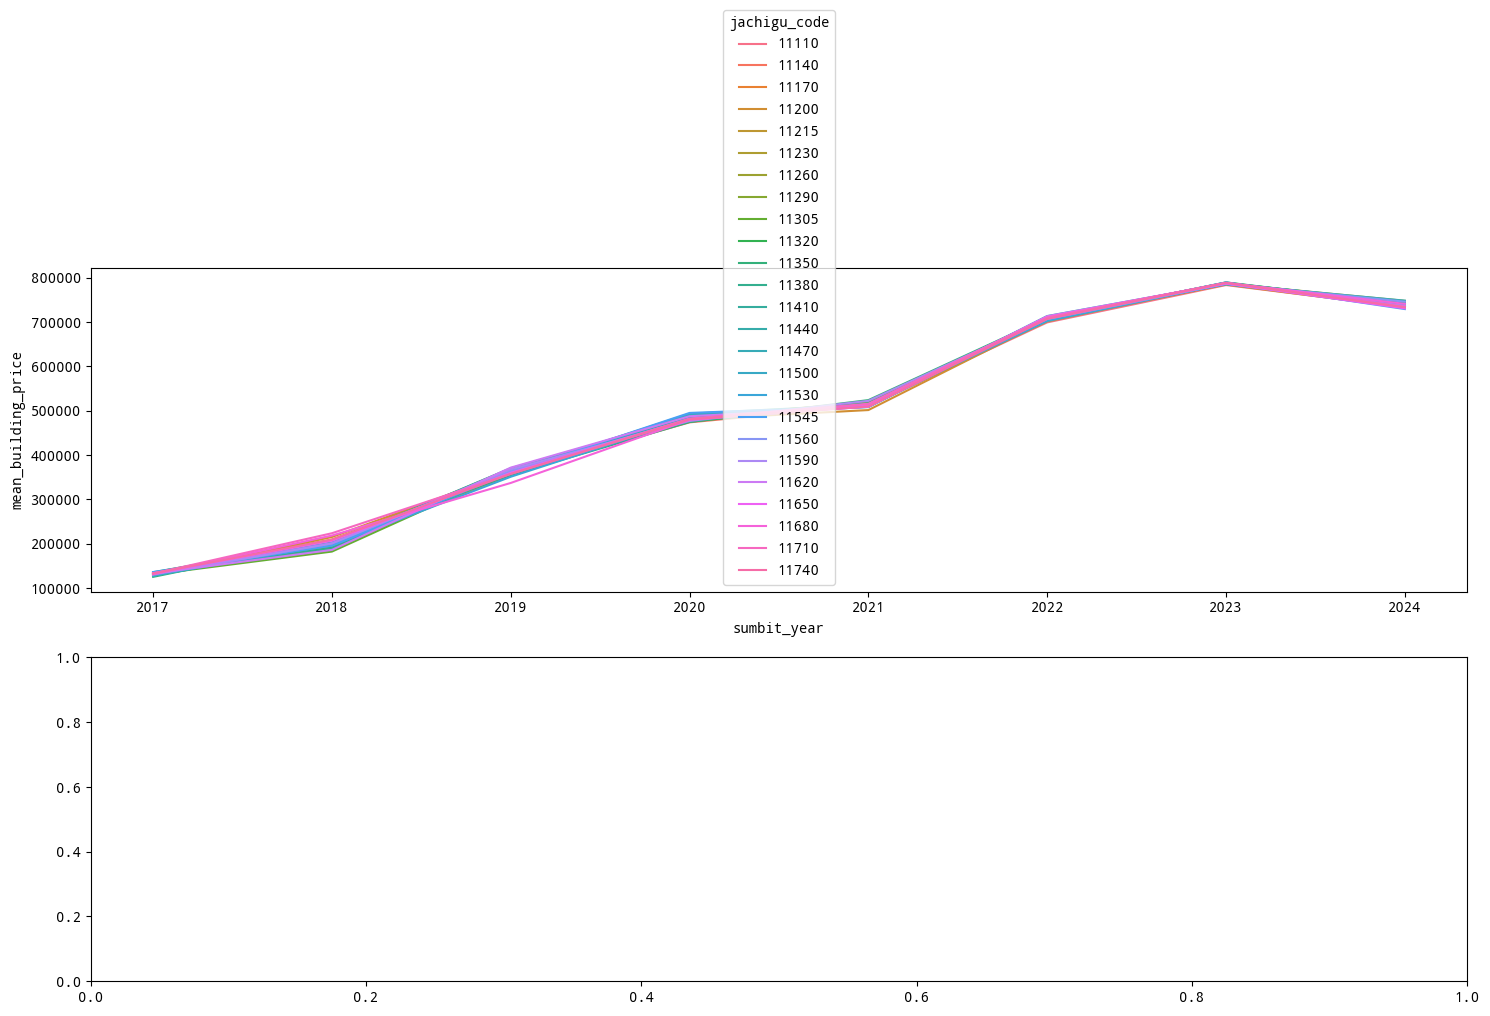

In [191]:
plt.figure(figsize = (15,10))

axes1 = plt.subplot(2,1,1)
sns.lineplot(data = pd_df.groupby(['jachigu_code','sumbit_year']).mean('building_price').reset_index().rename(columns = {'idx' : 'mean_building_price'})
            , x = pd_df.groupby(['jachigu_code','sumbit_year']).mean('building_price').reset_index().rename(columns = {'idx' : 'mean_building_price'})['sumbit_year']
            , y = pd_df.groupby(['jachigu_code','sumbit_year']).mean('building_price').reset_index().rename(columns = {'idx' : 'mean_building_price'})['mean_building_price']
            , hue = pd_df.groupby(['jachigu_code','sumbit_year']).mean('building_price').reset_index().rename(columns = {'idx' : 'mean_building_price'})['jachigu_code'])



axes2 = plt.subplot(2,1,2)


plt.tight_layout()
plt.show()

# 4. 학습 모델 생성 및 평가

## 4-1) 학습용 데이터 프레임 생성

In [28]:
df_forML = df_tbAPTPrice.drop('jachigu_name'
                   , 'law_name'
                   , 'jibun_gubun'
                   , 'jibun_name'
                   , 'building_name'
                    )

### 4-1-1) Encoding
**1) 문자열 → 숫자형 (cast)**
- `building_price`
- `sumbit_year`
- `building_size`
- `floor`
- `building_year`

---
**2) 범주형 컬럼 처리**
2-1) **Label Encoding**
- `jachigu_code`
- `law_code`

2-2) **One-Hot Encoding**
- `building_usage`

---




In [29]:
tmp_df = df_forML

In [30]:
# 범주 개수 확인
tmp_df.select("jachigu_code").distinct().count(), tmp_df.select("law_code").distinct().count(), tmp_df.select("building_usage").distinct().count()

(25, 86, 4)

In [31]:
## 문자열 -> 숫자(cast)
tmp_df2 = tmp_df.withColumn('building_price', col('building_price').cast('float'))\
                .withColumn('building_size', col('building_size').cast('float'))\
                .withColumn('sumbit_year', col('sumbit_year').cast('int'))\
                .withColumn('floor', col('floor').cast('int'))\
                .withColumn('building_year', col('building_year').cast('int'))

In [32]:
tmp_df3 = tmp_df2.fillna({'floor':0})

In [33]:
## 범주형 변수 >> 정수형
indexers_jachigu_code = StringIndexer(inputCol = 'jachigu_code', outputCol = 'INDEX_'+'jachigu_code')
indexers_law_code = StringIndexer(inputCol = 'law_code', outputCol = 'INDEX_'+'law_code')
indexers_jachigu_code, indexers_law_code

tmp_df4 = indexers_jachigu_code.fit(tmp_df3).transform(tmp_df3)
tmp_df5 = indexers_law_code.fit(tmp_df4).transform(tmp_df4)
tmp_df5

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, floor: int, building_year: int, idx: int, INDEX_jachigu_code: double, INDEX_law_code: double]

In [34]:
indexers_building_usage = StringIndexer(inputCol = 'building_usage', outputCol = 'INDEX_' + 'building_usage')
tmp_df6 = indexers_building_usage.fit(tmp_df5).transform(tmp_df5)
tmp_df6

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, floor: int, building_year: int, idx: int, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_building_usage: double]

In [35]:
## one-hot encoding
encoders = OneHotEncoder(inputCol = 'INDEX_'+'building_usage', outputCol = 'ENCODE_' + 'building_usage')
encoders

tmp_df7 = encoders.fit(tmp_df6).transform(tmp_df6)
tmp_df7

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, floor: int, building_year: int, idx: int, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_building_usage: double, ENCODE_building_usage: vector]

### 4-1-2) Feature 선택

In [36]:
features_cols = ['INDEX_jachigu_code'
                , 'INDEX_law_code'
                , 'ENCODE_building_usage'
                , 'sumbit_year'
                , 'building_size'
                , 'building_year'
               ]

### 4-1-3) assembler를 통한 feature Vectorized

In [37]:
assembler = VectorAssembler(inputCols = features_cols
                            , outputCol = 'feature'
                           )
tmp_df8 = assembler.transform(tmp_df7)
tmp_df8.select('building_price', 'feature').show(truncate = False)

+--------------+--------------------------------------------------------+
|building_price|feature                                                 |
+--------------+--------------------------------------------------------+
|22500.0       |[24.0,25.0,0.0,0.0,1.0,2021.0,18.56999969482422,2021.0] |
|24675.0       |[24.0,25.0,0.0,0.0,1.0,2022.0,18.56999969482422,2021.0] |
|61000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,26.979999542236328,1981.0]|
|60000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,47.06999969482422,1971.0] |
|96000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,66.94999694824219,1971.0] |
|50900.0       |[22.0,31.0,1.0,0.0,0.0,2017.0,40.5,1984.0]              |
|65000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,77.36000061035156,1984.0] |
|50000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,47.06999969482422,1971.0] |
|52000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,76.5999984741211,1971.0]  |
|61000.0       |[22.0,31.0,1.0,0.0,0.0,2018.0,19.969999313354492,1975.0]|
|46000.0       |[22.0,31.0,1.0,0.0,0.0

### 4-1-4) 데이터 셋 분할

In [38]:
train_ratio = 0.8
test_ratio = 0.2

In [39]:
train_df, test_df = tmp_df8\
                    .randomSplit([train_ratio, test_ratio], seed = 42)

train_df, test_df


(DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, floor: int, building_year: int, idx: int, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_building_usage: double, ENCODE_building_usage: vector, feature: vector],
 DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, floor: int, building_year: int, idx: int, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_building_usage: double, ENCODE_building_usage: vector, feature: vector])

In [40]:
train_df.count()

671187

In [41]:
train_df = train_df.withColumnRenamed('building_price', 'label')

In [42]:
train_df = train_df.select("label", "feature")

## 4-2) 학습 모델

### 4-2-1) 선형 모델 생성

In [43]:
lr = LinearRegression(featuresCol = 'feature'
                       , labelCol = 'label')

lr

LinearRegression_3b508e25fefb

In [44]:
lr_model \
= lr.fit(train_df)

lr_model

24/12/19 17:26:55 WARN Instrumentation: [1a66ce89] regParam is zero, which might cause numerical instability and overfitting.
24/12/19 17:26:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/19 17:26:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/19 17:27:03 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/19 17:27:03 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


LinearRegressionModel: uid=LinearRegression_3b508e25fefb, numFeatures=8

### 4-2-2) 학습 모델 결과

In [45]:
predictions = lr_model.transform(test_df)
predictions.selectExpr(predictions.columns[:-6] + [predictions.columns[-1]]).show(truncate = False)

predictions.select('idx', 'building_price', 'prediction')\
            .withColumn('gap', col('building_price') - col('prediction'))\
            .orderBy(col('gap'))\
            .show(truncate = False)

+------------+--------+--------------+-----------+--------------+-------------+-----+-------------+------+------------------+
|jachigu_code|law_code|building_usage|sumbit_year|building_price|building_size|floor|building_year|idx   |prediction        |
+------------+--------+--------------+-----------+--------------+-------------+-----+-------------+------+------------------+
|11170       |12900   |연립다세대    |2017       |28000.0       |38.81        |3    |1991         |79170 |17443.634895160794|
|11170       |12900   |연립다세대    |2017       |40000.0       |36.26        |4    |1971         |26472 |17530.19430470094 |
|11170       |12900   |연립다세대    |2017       |40000.0       |47.68        |1    |1971         |169036|24779.612625287846|
|11170       |12900   |연립다세대    |2017       |44800.0       |47.07        |1    |1971         |169446|24392.384181141853|
|11170       |12900   |연립다세대    |2017       |46000.0       |47.14        |3    |1971         |22710 |24436.819993922487|
|11170       |129

+------+--------------+------------------+-------------------+
|idx   |building_price|prediction        |gap                |
+------+--------------+------------------+-------------------+
|219327|970000.0      |2282640.4848247413|-1312640.4848247413|
|695371|580000.0      |1882482.4059219435|-1302482.4059219435|
|520579|710000.0      |1375267.1010468341|-665267.1010468341 |
|593870|480000.0      |1121998.9560471997|-641998.9560471997 |
|504208|590000.0      |1224762.2151359618|-634762.2151359618 |
|37706 |450000.0      |1070579.0404320005|-620579.0404320005 |
|375201|330000.0      |906598.4144523777 |-576598.4144523777 |
|600054|350000.0      |880233.7104337048 |-530233.7104337048 |
|240281|455000.0      |960206.341527421  |-505206.341527421  |
|379094|171000.0      |659100.5426052008 |-488100.5426052008 |
|340644|225000.0      |708334.4119393956 |-483334.4119393956 |
|529800|250000.0      |727750.9779231548 |-477750.97792315483|
|622231|300000.0      |777418.8773826193 |-477418.87738

### 4-2-3) 학습 평가

In [46]:
evaluator = RegressionEvaluator(
    labelCol="building_price",
    predictionCol="prediction",
    metricName="rmse"  # Root Mean Squared Error
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 60297.65992143047


In [47]:
evaluator = RegressionEvaluator(labelCol="building_price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared (R²): {r2}")


R-squared (R²): 0.433095200846465


In [48]:
evaluator = RegressionEvaluator(labelCol="building_price", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 25759.766987465446


In [49]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [-27.24196973054434,453.88212381213884,4099.242069980269,41034.26455788227,5306.44469057298,6249.0617251036365,634.8000929396344,-85.26507918956356]
Intercept: -12459357.94902529


### 4-2-4) 학습 결과

굉장히 좋지 못한 성능인 것 같으며, 여러 요인을 feature에 담거나 모델 개선이 필요하다

# 5. 학습 예측값 DB 저장

In [71]:
predictions.select('idx', 'prediction')\
    .write.format('jdbc')\
    .options(
        url = mysql_url
        , driver = 'com.mysql.jdbc.Driver'
        , dbtable = 'lg_prediction'
        , user = user_id
        , password = user_password
            )\
    .mode('append')\
    .save()

In [192]:
ss.stop()